Steps:

Pretrain stage

1. For each layer, define 4 scalars for each activation
2. Fit till convergence on cameraman

Test stage

- Start from this init on cameraman
- Start from this init on tokyo512

# Pretrain

In [1]:
! nvidia-smi

Fri May 12 11:19:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P8    22W /  70W |      2MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [4]:
from train_pipeline import train

import os
import torch
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf


def load_cfg(overrides=()):
    # with initialize_config_dir(config_dir="/app/notebooks/draft_02/conf"):
    with initialize(version_base=None, config_path="./conf"):
        cfg = compose(config_name='config', overrides=list(overrides))
        return cfg

from IPython.display import clear_output

import lovely_tensors as lt
lt.monkey_patch()

cfg = load_cfg(overrides=[
    "+exp=01_splitnet_posenc",
    "random_seed=[0]",
    "image=cameraman",
    "+device=cuda:0",
])

print(OmegaConf.to_yaml(cfg))
# train(cfg)

In [5]:
init_coeffs = torch.ones(3, 4)
init_coeffs.requires_grad = True
init_coeffs

tensor[3, 4] n=12 x∈[1.000, 1.000] μ=1.000 σ=0. grad

In [6]:
# model = instantiate(cfg.model, out_features=1)
# net = model.networks[0].net

# for i, (layer) in enumerate(net):
#     fan_out = layer.linear.weight.data.shape[0]//4
    
#     for c in range(4):
#         layer.linear.weight.data[fan_out*c:fan_out*(c+1)] *= init_coeffs[i, c]

In [7]:
# (layer.linear.weight.data @ torch.randn(1000, 128).T).T

In [8]:
# model(x).sum().backward()

In [9]:
import torch
from torch import nn
import torch.nn.functional as F

import os
import math
import numpy as np

def init_siren(W, fan_in, omega=30, init_c=24, flic=2, is_first=False):
    if is_first:
        c = flic / fan_in
    else:
        c = np.sqrt(init_c / fan_in) / omega
    W.uniform_(-c, c)

    
def U(*shape, r=1):
    x = torch.rand(*shape)

    x = (x-0.5)*(2*r)
    return x
    
class RawSplitLayer(nn.Module):
    def __init__(self, input_dim, output_dim, m=1.0, omegas=(1, 1, 1.0, 1), use_bias=True):
        super().__init__()
        # self.linear = nn.Linear(input_dim, output_dim * 4, bias=use_bias)

        self.W = U(output_dim * 4, input_dim)
        self.b = torch.zeros(output_dim * 4)

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.m = m
        self.omegas = omegas
        # self.init_weights()
        k = (1/self.W.shape[1])**0.5
        torch.nn.init.uniform_(self.W, -k, k)
        
        
    def parameters(self): return [self.W, self.b]

    
    def scale_weights(self, c):
        fo = self.output_dim # fan_out
        for i in range(4):
            # self.W[i*fo:(i+1)*fo] = c[i] * self.W[i*fo:(i+1)*fo]
            self.W[i*fo:(i+1)*fo] *= self.W[i*fo:(i+1)*fo]
    
    def init_weights(self):
        s = self.output_dim
        fan_in = self.input_dim

        W = self.linear.weight.data
        self.linear.bias.data.uniform_(0, 0)
        c = np.sqrt(1 / fan_in) / self.omegas[0]
        # print('the c', c)
        W[:s].uniform_(-c, c)
        # init_siren(W[:s], init_c=1, fan_in=fan_in, is_first=False, omega=self.omegas[0])
        
        init_siren(W[s:s*2],init_c=6, fan_in=fan_in, is_first=False, omega=self.omegas[1])
        init_siren(W[s*2:], fan_in=fan_in, is_first=False, omega=self.omegas[2])

        
    
    def to(self, *args, **kwargs):
        self.W = self.W.to(*args, **kwargs)
        self.b = self.b.to(*args, **kwargs)

    def forward(self, *args, **kwargs):
        h, acts = self.forward_with_activations(*args, **kwargs)
        return h

    def expand_c(self, c):
        fo = self.output_dim
        c_expanded = torch.cat([c[i].expand(fo) for i in range(4)])[:, None]
        return c_expanded

    def forward_with_activations(self, x, c):
        preact = ( (self.W * self.expand_c(c)) @x.T).T + self.b
        preacts = preact.chunk(4, dim=-1)
        preacts = list(preacts)

        for i in range(len(preacts)):
            preacts[i] = self.omegas[i] * preacts[i]

        preact_tanh, preact_sigmoid, preact_sin, preact_cos = preacts
        act_tanh, act_sigmoid, act_sin, act_cos = preact_tanh.tanh(), preact_sigmoid.sigmoid(), preact_sin.sin(), preact_cos.cos()
        h = act_tanh * act_sigmoid * act_sin * act_cos

        h = h * self.m

        return h, [x, preact, preact_tanh, preact_sigmoid, preact_sin, preact_cos, act_tanh, act_sigmoid, act_sin, act_cos]

In [10]:
class RawSimpleSplitNet(nn.Module):
    def __init__(self, in_features, hidden_layers, out_features, outermost_linear=False, use_bias=True, omegas=(1, 1, 1.0, 1), m=1.0):
        super().__init__()

        if not hasattr(m, '__len__'):
            m = [m] * (len(hidden_layers)+2)
            
        is_layerwise_omegas = hasattr(omegas[0], '__len__')
        
        if not is_layerwise_omegas:
            omegas = [omegas] * (len(hidden_layers)+2)

        net = [RawSplitLayer(in_features, hidden_layers[0], use_bias=use_bias, m=m[0], omegas=omegas[0])]

        fan_out = hidden_layers[0]
        for i, (fan_in, fan_out) in enumerate ( zip(hidden_layers, hidden_layers[1:]) ):
            net.append(RawSplitLayer(fan_in, fan_out, use_bias=use_bias, m=m[i+1], omegas=omegas[i+1]))

        if outermost_linear:
            net.append(nn.Linear(fan_out, out_features))
        else:
            net.append(RawSplitLayer(fan_out, out_features, m=m[-1]))
            
            
        self.net = net
        self.cs = torch.ones(len(net), 4)

    def parameters(self):
        return [p for l in self.net for p in l.parameters()]

    
    def to(self, *args, **kwargs):
        for l in self.net:
            l.to(*args, **kwargs)
            
        self.cs = self.cs.to(*args, **kwargs)
    
    def requires_grad_(self, flag):
        for p in self.parameters():
            p.requires_grad_(flag)

    def forward(self, x):
        for i, layer in enumerate(self.net):
            x = layer(x, self.cs[i])
        return x

    def forward_with_activations(self, x):
        h = x
        intermediate_acts = []

        for layer in self.net:
            if isinstance(layer, RawSplitLayer):
                h, acts = layer.forward_with_activations(h)
            else:
                h = layer(h)
                acts = []

            intermediate_acts.append((h, acts))

        return h, intermediate_acts


In [11]:
cfg = load_cfg(overrides=[
    "+exp=01_splitnet_posenc",
    "random_seed=[0]",
    "image=cameraman",
    "+device=cuda:0",
])

cfg.optimizer.lr = 1e-1

In [12]:
def init_raw_model():
    model = RawSimpleSplitNet(in_features=128*2, hidden_layers=[128,128], out_features=1, m=[10,10,1])
    for l in model.net:
        l.W = l.W.detach()
        l.b = l.b.detach()
    model.to(device)
    model.requires_grad_(True)
    return model

In [13]:
from tqdm.auto import tqdm

In [14]:
from train_pipeline import *

In [15]:
# model = instantiate(cfg["model"], out_features=out_features).to(device)
# raw_model = init_raw_model()

Setting seed to 43
********************************************************************************


image: cameraman
image_dir: ../../data
image_W: 512
use_wandb: true
is_debug: false
total_steps: 3000
random_seed:
- 0
model:
  _target_: spellbook.parallel.ParallelSplitNet
  model_configs:
  - hidden_layers:
    - 128
    - 128
    m:
    - 10.0
    - 10.0
    - 1.0
logging:
  logger:
    _target_: spellbook.logging.wandb.WandbLogger
    project: 01_splitnet__${image}
  steps_till_summary: 500
  experiment_name: splitnet_posenc__baseline
optimizer:
  _target_: torch.optim.AdamW
  weight_decay: 0.0
  lr: 0.1
device: cuda:0


********************************************************************************


  0%|          | 0/100 [00:00<?, ?it/s]

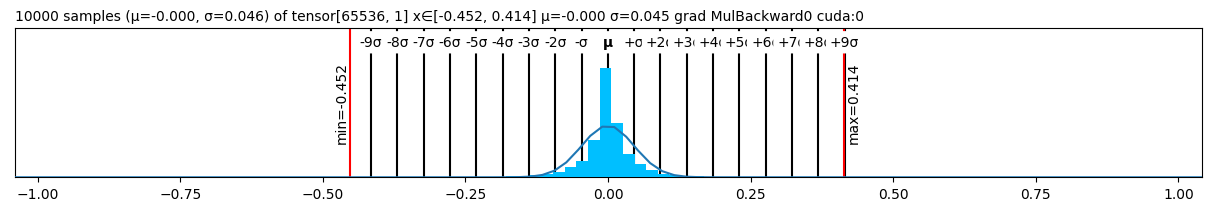

Step 0, psnr=4.865118


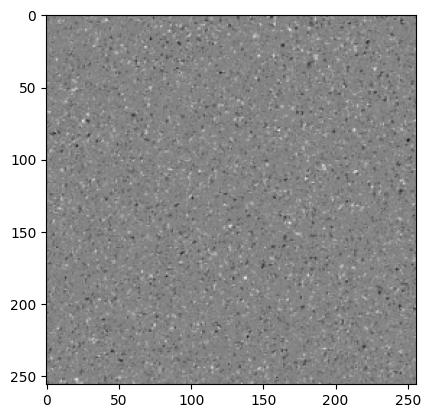

In [20]:
random_seed = 43
seed_all(random_seed)
print("Setting seed to", random_seed)

print("*" * 80)
print("\n")
print(OmegaConf.to_yaml(cfg))
print()
print("*" * 80)

device = cfg["device"]

model_input, ground_truth, H, W = load_data(cfg)


out_features = ground_truth.shape[-1]

if False:
    model = instantiate(cfg["model"], out_features=out_features).to(device)

else:
    import rff
    encoding_size = 128
    encoding = rff.layers.GaussianEncoding(sigma=10.0, input_size=2, encoded_size=encoding_size)
    model_input = encoding(model_input)

    model = init_raw_model()
    
    model.requires_grad_(False)
    model.cs.requires_grad_(True)
    
    model_input = model_input.squeeze(0)
    ground_truth = ground_truth.squeeze(0)

model_input, ground_truth = model_input.to(device), ground_truth.to(device)

total_steps = cfg["total_steps"]
steps_til_summary = cfg.logging["steps_till_summary"]
batch_size = cfg.get('batch_size', None)

# total_params = count_parameters(model)
# 
# logger.log_dict({"total_params": total_params})

# optimizer = instantiate(cfg.optimizer, params=model.parameters())
optimizer = instantiate(cfg.optimizer, params=[model.cs])

pbar = tqdm(range(100))
for step in pbar:
    if batch_size:
        idxs = torch.randint(0, model_input.shape[1], (batch_size,))
        model_input_batch = model_input[:, idxs]
        ground_truth_batch = ground_truth[:, idxs]
        if step < 2:
            print('model_input.shape', model_input.shape)
            print('model_input_batch.shape', model_input_batch.shape)
    else:
        model_input_batch = model_input
        ground_truth_batch = ground_truth

    model_output_batch = model(model_input_batch)
    if step == 0:
        display ( model_output_batch.plt )
    mse, psnr = mse_and_psnr(model_output_batch, ground_truth_batch)
    loss = mse

    log_dic = {"step": step, "mse": mse.item(), "psnr": psnr.item()}
    pbar.set_description(f'psnr={psnr:.3f}')

    if not step % steps_til_summary:
        print(f"Step {step}, psnr={psnr:0.6f}")
        # img_grad_tensor = gradient(model_output, coords)
        # img_laplacian_tensor = laplace(model_output, coords)

        with torch.inference_mode():
            model_output = model(model_input)

        img = imagify_tensor(model_output, H, W)
        # img_grad = imagify_tensor(img_grad_tensor.norm(dim=-1))
        # img_laplacian = imagify_tensor(img_laplacian_tensor)

        colage = img
        plt.imshow(colage)
        plt.show()


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

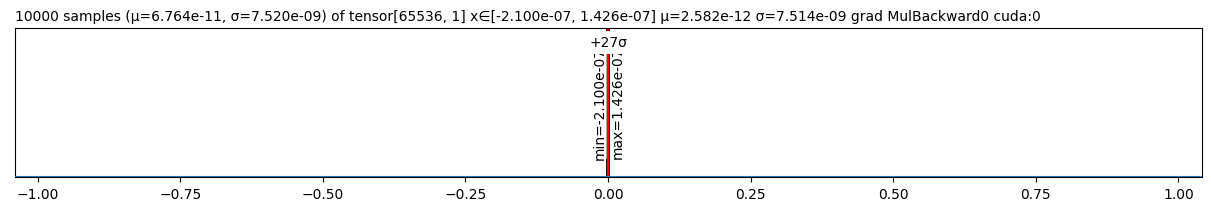

In [21]:
model_output_batch.plt

In [24]:
model.cs.v

tensor[3, 4] n=12 x∈[0.301, 1.701] μ=0.657 σ=0.606 grad cuda:0
tensor([[0.3012, 0.3405, 0.3008, 1.7011],
        [0.3033, 0.3148, 0.3067, 1.6476],
        [0.3131, 0.4098, 0.3149, 1.6314]], device='cuda:0', requires_grad=True)

In [32]:
cs = torch.tensor([[0.3012, 0.3405, 0.3008, 1.7011],
        [0.3033, 0.3148, 0.3067, 1.6476],
        [0.3131, 0.4098, 0.3149, 1.6314]])

In [33]:
cs

tensor[3, 4] n=12 x∈[0.301, 1.701] μ=0.657 σ=0.606

In [22]:
break

SyntaxError: 'break' outside loop (668683560.py, line 4)

In [34]:
cfg = load_cfg(overrides=[
    "+exp=01_splitnet_posenc",
    "random_seed=[0]",
    "image=cameraman",
    "+device=cuda:0",
])

Setting seed to 43
********************************************************************************


image: cameraman
image_dir: ../../data
image_W: 512
use_wandb: true
is_debug: false
total_steps: 3000
random_seed:
- 0
model:
  _target_: spellbook.parallel.ParallelSplitNet
  model_configs:
  - hidden_layers:
    - 128
    - 128
    m:
    - 10.0
    - 10.0
    - 1.0
logging:
  logger:
    _target_: spellbook.logging.wandb.WandbLogger
    project: 01_splitnet__${image}
  steps_till_summary: 500
  experiment_name: splitnet_posenc__baseline
optimizer:
  _target_: torch.optim.AdamW
  weight_decay: 0.0
  lr: 0.0001
device: cuda:0


********************************************************************************


  0%|          | 0/3000 [00:00<?, ?it/s]

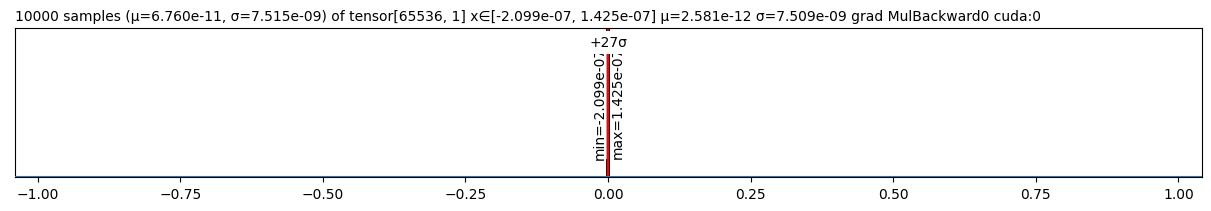

Step 0, psnr=4.892826


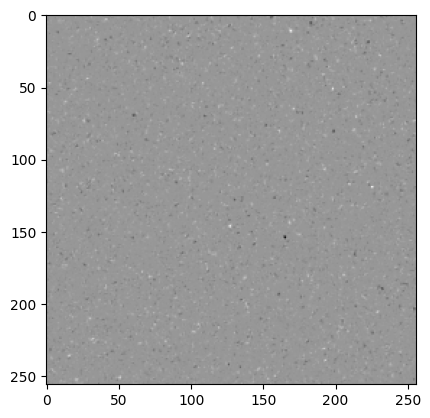

Step 500, psnr=7.093236


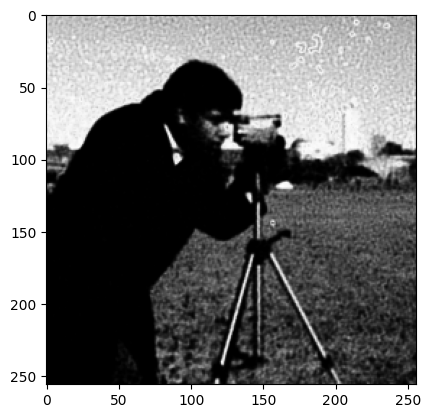

Step 1000, psnr=7.153094


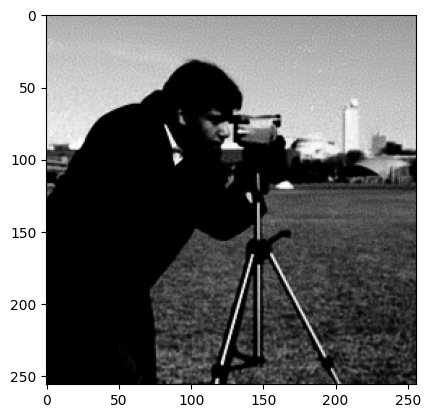

Step 1500, psnr=19.170631


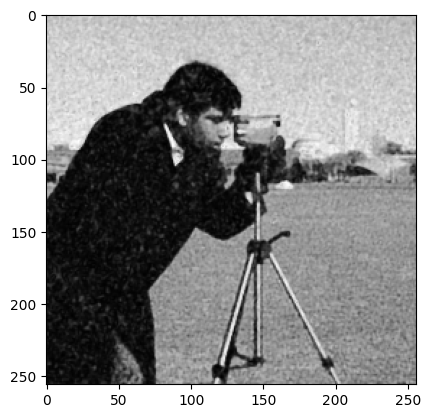

Step 2000, psnr=32.294395


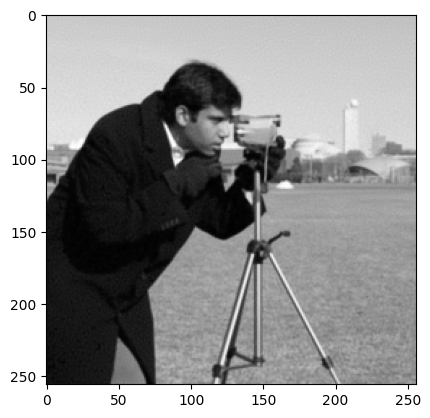

Step 2500, psnr=35.369637


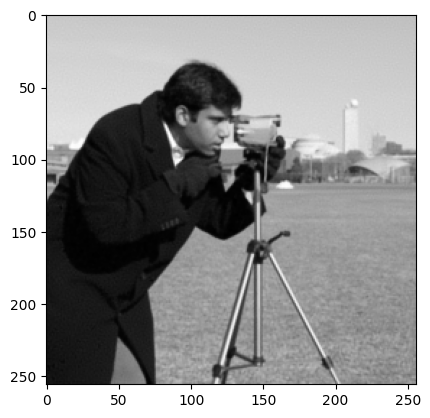

In [35]:
random_seed = 43
seed_all(random_seed)
print("Setting seed to", random_seed)

print("*" * 80)
print("\n")
print(OmegaConf.to_yaml(cfg))
print()
print("*" * 80)

device = cfg["device"]

model_input, ground_truth, H, W = load_data(cfg)


out_features = ground_truth.shape[-1]

if False:
    model = instantiate(cfg["model"], out_features=out_features).to(device)

else:
    import rff
    encoding_size = 128
    encoding = rff.layers.GaussianEncoding(sigma=10.0, input_size=2, encoded_size=encoding_size)
    model_input = encoding(model_input)

    model = init_raw_model()
    model.cs = cs.to(device)
    # model.cs = cs.to(device)
    # model.requires_grad_(False)
    # model.cs.requires_grad_(True)
    
    model_input = model_input.squeeze(0)
    ground_truth = ground_truth.squeeze(0)

model_input, ground_truth = model_input.to(device), ground_truth.to(device)

total_steps = cfg["total_steps"]
steps_til_summary = cfg.logging["steps_till_summary"]
batch_size = cfg.get('batch_size', None)

# total_params = count_parameters(model)
# 
# logger.log_dict({"total_params": total_params})

optimizer = instantiate(cfg.optimizer, params=model.parameters())
# optimizer = instantiate(cfg.optimizer, params=[model.cs])

pbar = tqdm(range(total_steps))
for step in pbar:
    if batch_size:
        idxs = torch.randint(0, model_input.shape[1], (batch_size,))
        model_input_batch = model_input[:, idxs]
        ground_truth_batch = ground_truth[:, idxs]
        if step < 2:
            print('model_input.shape', model_input.shape)
            print('model_input_batch.shape', model_input_batch.shape)
    else:
        model_input_batch = model_input
        ground_truth_batch = ground_truth

    model_output_batch = model(model_input_batch)
    if step == 0:
        display ( model_output_batch.plt )
    mse, psnr = mse_and_psnr(model_output_batch, ground_truth_batch)
    loss = mse

    log_dic = {"step": step, "mse": mse.item(), "psnr": psnr.item()}
    pbar.set_description(f'psnr={psnr:.3f}')

    if not step % steps_til_summary:
        print(f"Step {step}, psnr={psnr:0.6f}")
        # img_grad_tensor = gradient(model_output, coords)
        # img_laplacian_tensor = laplace(model_output, coords)

        with torch.inference_mode():
            model_output = model(model_input)

        img = imagify_tensor(model_output, H, W)
        # img_grad = imagify_tensor(img_grad_tensor.norm(dim=-1))
        # img_laplacian = imagify_tensor(img_laplacian_tensor)

        colage = img
        plt.imshow(colage)
        plt.show()


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
net = RawSimpleSplitNet(32, [32,32], 32)
net.cs.requires_grad_(True)

In [ ]:
net(torch.randn(12, 32)).sum().backward()

In [ ]:
net.cs.grad

In [ ]:
x = torch.randn(1000, 64)
net = RawSplitLayer(64, 64)
net(x, c).sum().backward()

In [ ]:
self = net

In [ ]:

c_expanded

In [ ]:
self.W * c_expanded

In [ ]:
c[0].expand(10)

In [ ]:
layer.linear.weight.data.chunk(4, 0)

In [ ]:
from train_pipeline import *

In [ ]:
def _train_seed(cfg, random_seed=0):
    seed_all(random_seed)
    print("Setting seed to", random_seed)
    is_debug = cfg.get("is_debug")

    project = str(cfg.logging.logger.project).replace(".jpg", "_jpg").replace(".png", "_png")

    if is_debug:
        project = "DEBUG__" + project

    logger = instantiate(
        cfg.logging.logger,
        project=project,
        group=cfg.logging.experiment_name,
        name=f"rs{random_seed}",
    )

    print("*" * 80)
    print("\n")
    print(OmegaConf.to_yaml(cfg))
    print()
    print("*" * 80)

    device = cfg["device"]

    model_input, ground_truth, H, W = load_data(cfg)
    model_input, ground_truth = model_input.to(device), ground_truth.to(device)

    out_features = ground_truth.shape[-1]
    model = instantiate(cfg["model"], out_features=out_features)
    model.to(device)

    total_steps = cfg["total_steps"]
    steps_til_summary = cfg.logging["steps_till_summary"]
    batch_size = cfg.get('batch_size', None)

    total_params = count_parameters(model)

    logger.log_dict({"total_params": total_params})

    optimizer = instantiate(cfg.optimizer, params=model.parameters())

    for step in range(total_steps):
        if batch_size:
            idxs = torch.randint(0, model_input.shape[1], (batch_size,))
            model_input_batch = model_input[:, idxs]
            ground_truth_batch = ground_truth[:, idxs]
            if step < 2:
                print('model_input.shape', model_input.shape)
                print('model_input_batch.shape', model_input_batch.shape)
        else:
            model_input_batch = model_input
            ground_truth_batch = ground_truth

        model_output_batch = model(model_input_batch)
        mse, psnr = mse_and_psnr(model_output_batch, ground_truth_batch)
        loss = mse

        log_dic = {"step": step, "mse": mse.item(), "psnr": psnr.item()}
        logger.log_dict(log_dic)

        if not step % steps_til_summary:
            print(f"Step {step}, Total loss {loss:0.6f}")
            # img_grad_tensor = gradient(model_output, coords)
            # img_laplacian_tensor = laplace(model_output, coords)

            with torch.inference_mode():
                model_output = model(model_input)

            img = imagify_tensor(model_output, H, W)
            # img_grad = imagify_tensor(img_grad_tensor.norm(dim=-1))
            # img_laplacian = imagify_tensor(img_laplacian_tensor)

            colage = img
            plt.imshow(colage)
            plt.show()

            logger.log_image(colage, name="pred_image")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return model